# Fair Face Recogniotion project

Bence Zoltan Balazs (beba@itu.dk), Thomas Fosdam Claudinger (thcl@itu.dk)

IT University of Copenhagen, May 19, 2023

**Imports**

In [1]:
from face_recognition import face_locations
import face_recognition
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

import pandas as pd
import seaborn as sns

import pickle

### Skip running grid on decision tree?

Training takes a few minutes due to grid search

In [2]:
skip_tree = False

## 1. Trying out face_recognition package

Prediction 0
prediction: []


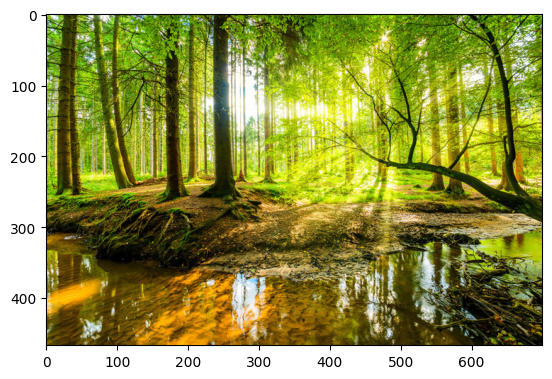


Prediction 1
prediction: [(590, 1659, 975, 1274)]


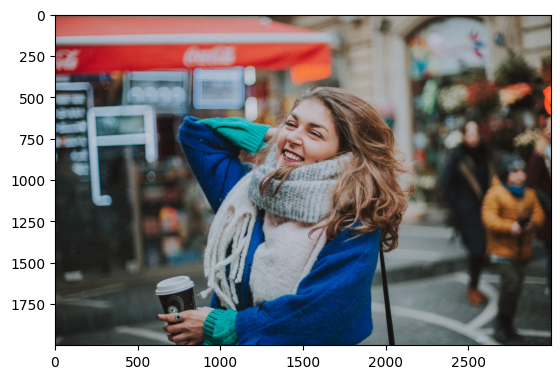

In [3]:
run_test = True

if run_test == True:
    # Download the image from the web
    urls = [
        'https://static.posters.cz/image/750/plakater/spring-forrest-i101995.jpg',
        'https://images.pexels.com/photos/1035671/pexels-photo-1035671.jpeg?cs=srgb&dl=pexels-anastasiya-lobanovskaya-1035671.jpg&fm=jpg'
        ]

    for i, url in enumerate(urls):
        print(f"Prediction {i}")
        response = requests.get(url)

        # Open the image using Pillow
        img = Image.open(BytesIO(response.content))

        # Convert the image to a numpy array
        img_array = np.asarray(img)

        # Find all the faces in the image
        print("prediction:", face_locations(img_array))

        # Show the image
        plt.imshow(img_array)
        plt.show()

        print()



## 2. Data exploring

In [4]:
# Read in all files from the dataset as dataframes.
list_eval_partition = pd.read_csv('../data/celeb_dataset/list_eval_partition.csv')
list_bbox_celeba = pd.read_csv('../data/celeb_dataset/list_bbox_celeba.csv')
list_landmarks_celeba = pd.read_csv('../data/celeb_dataset/list_landmarks_align_celeba.csv')
list_attr_celeba = pd.read_csv('../data/celeb_dataset/list_attr_celeba.csv')


display(list_eval_partition.head())
print("list_eval_partition.csv: \nRecommended partitioning of images into training, validation, testing sets. \
      \nImages 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing.\n\n")

display(list_bbox_celeba.head())
print('list_bbox_celeba.csv: \
      \nBounding box information for each image. "x_1" and "y_1" represent the upper left \
      \npoint coordinate of bounding box. "width" and "height" represent the width and height of bounding box\n\n')

display(list_landmarks_celeba.head())
print("list_landmarks_align_celeba.csv: \
      \nImage landmarks and their respective coordinates. There are 5 landmarks: \
      \nleft eye, right eye, nose, left mouth, right mouth\n\n")

display(list_attr_celeba.head())
print('list_attr_celeba.csv: \
      \nAttribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative\n\n')


,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


list_eval_partition.csv: 
Recommended partitioning of images into training, validation, testing sets.       
Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing.




,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


list_bbox_celeba.csv:       
Bounding box information for each image. "x_1" and "y_1" represent the upper left       
point coordinate of bounding box. "width" and "height" represent the width and height of bounding box




,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


list_landmarks_align_celeba.csv:       
Image landmarks and their respective coordinates. There are 5 landmarks:       
left eye, right eye, nose, left mouth, right mouth




,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


list_attr_celeba.csv:       
Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative




In [5]:
# We are gonna focus on the attributes for now.

display(list_attr_celeba.head().T)

,0,1,2,3,4
image_id,000001.jpg,000002.jpg,000003.jpg,000004.jpg,000005.jpg
5_o_Clock_Shadow,-1,-1,-1,-1,-1
Arched_Eyebrows,1,-1,-1,-1,1
Attractive,1,-1,-1,1,1
Bags_Under_Eyes,-1,1,-1,-1,-1
Bald,-1,-1,-1,-1,-1
Bangs,-1,-1,-1,-1,-1
Big_Lips,-1,-1,1,-1,1
Big_Nose,-1,1,-1,-1,-1
Black_Hair,-1,-1,-1,-1,-1


## Distribution of labels

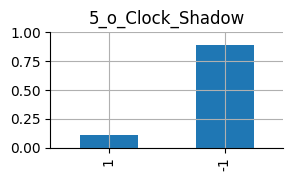

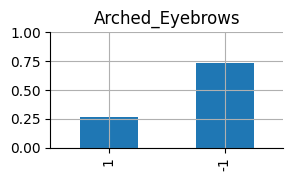

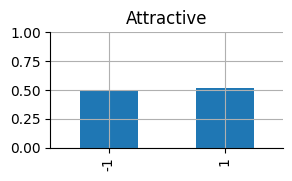

The rest are saved in ../figures/dataset_barplots/


In [6]:
# bar plot
for idx, feature in enumerate(list(list_attr_celeba.columns[1:])):
    plt.figure(figsize=(3, 1.5))
    (list_attr_celeba[feature].value_counts(normalize=True)).plot(kind='bar')
    sns.despine(top=True, right=True)
    # sns.countplot(x=feature, data=attr_df)
    plt.title(feature)
    # y max limit
    plt.ylim(0, 1)
    # sort x axis descending
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.savefig('../figures/dataset_barplots/' + feature + '.png', bbox_inches='tight')

    if idx in [0, 1, 2]:
        plt.show()

    plt.close()

print("The rest are saved in ../figures/dataset_barplots/")

## Eda with sweetviz

/Users/thomas/.pyenv/versions/3.11.1/envs/fairness/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/thomas/.pyenv/versions/3.11.1/envs/fairness/lib/python3.11/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/thomas/.pyenv/versions/3.11.1/envs/fairness/lib/python3.11/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: image_id                            |▏         | [  2%]   00:00 -> (00:04 left)/Users/thomas/.pyenv/v


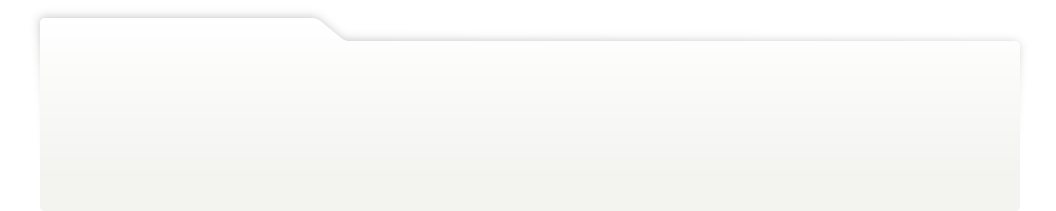
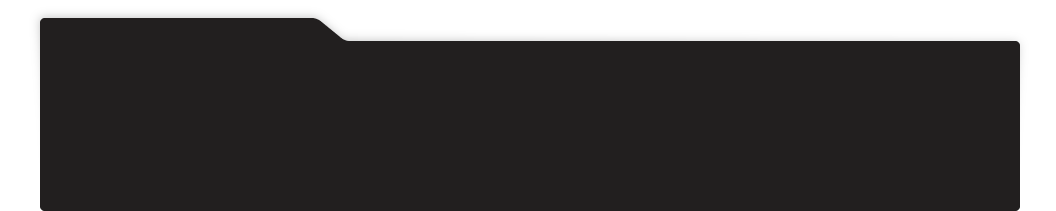
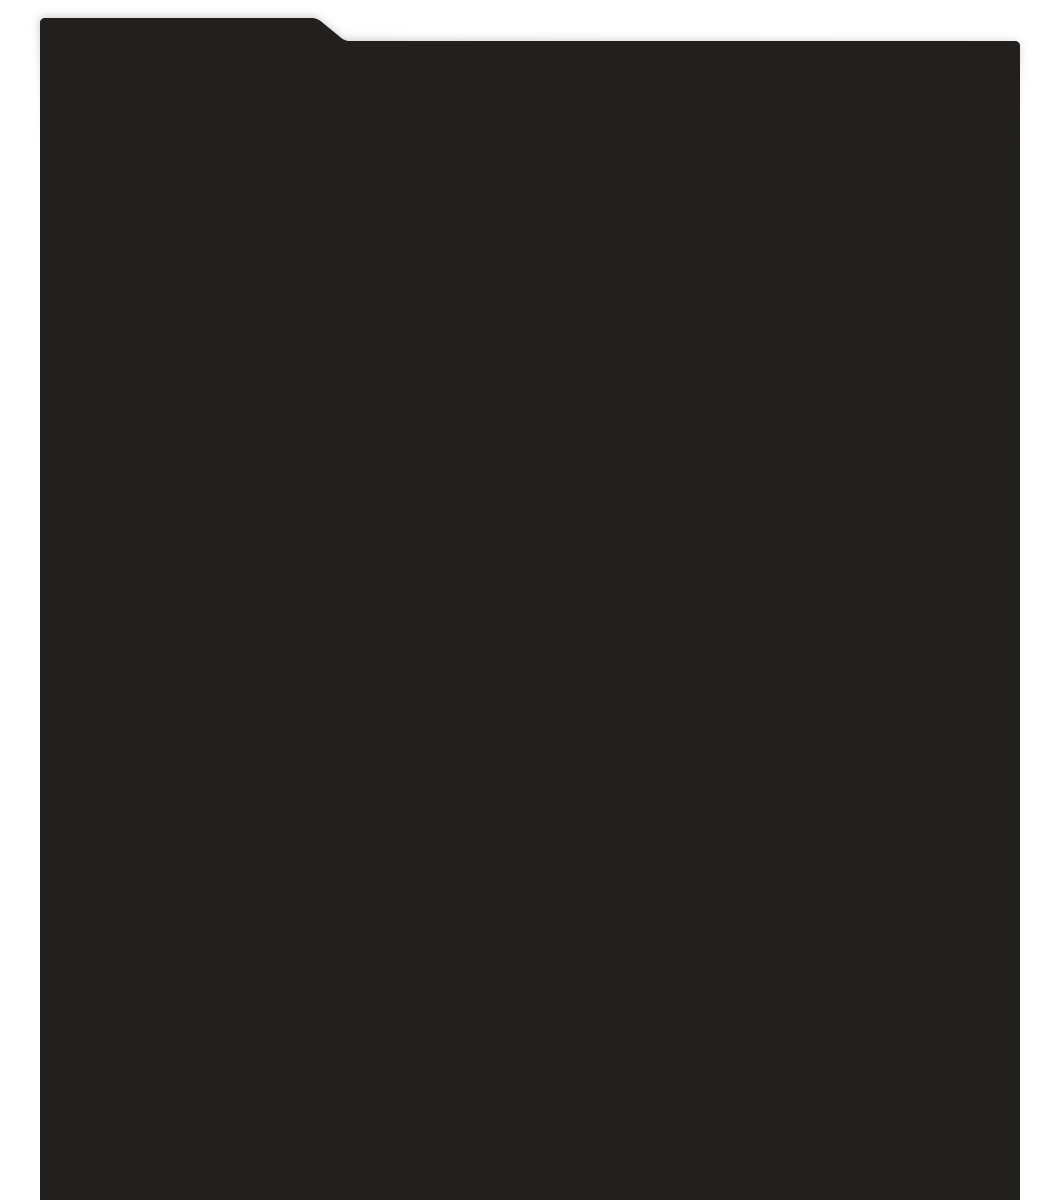
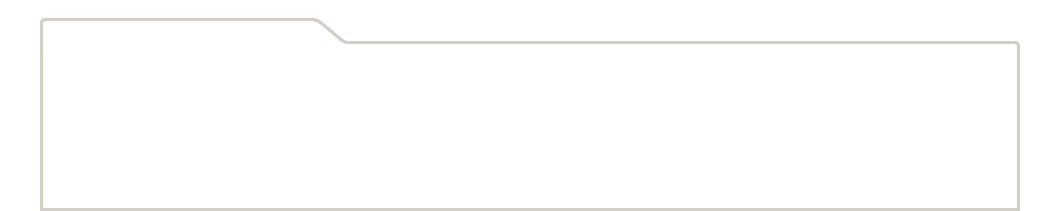
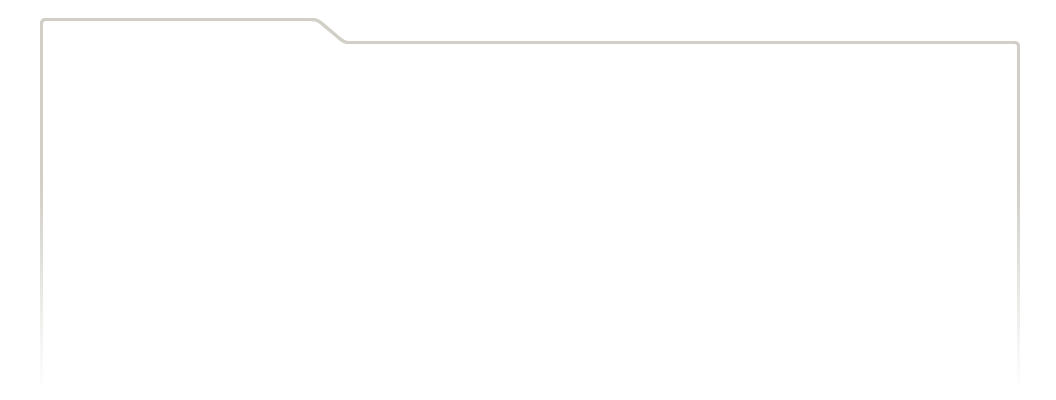
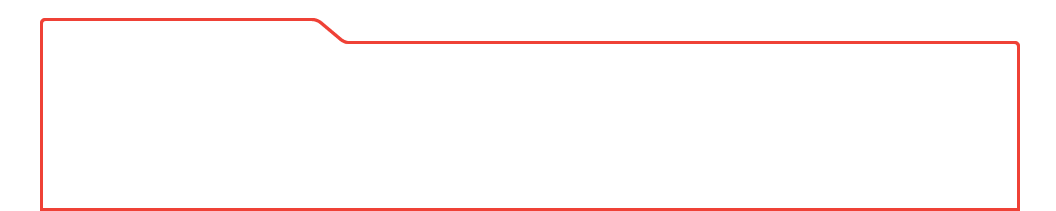
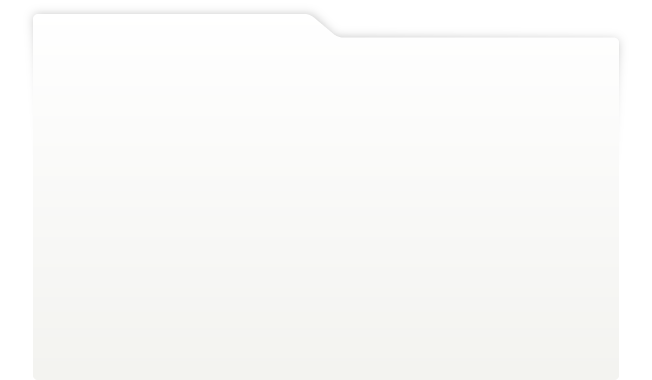
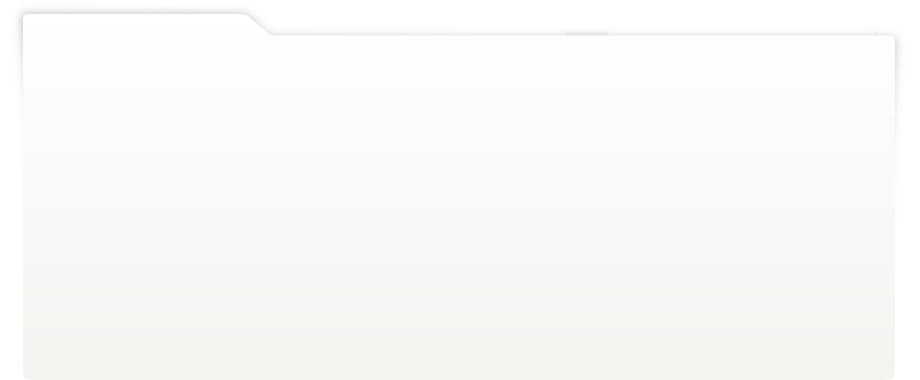
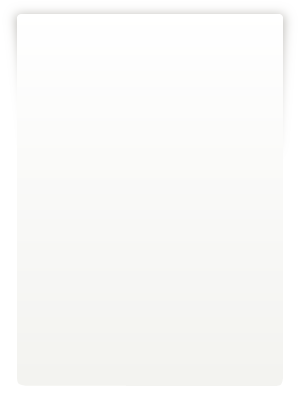
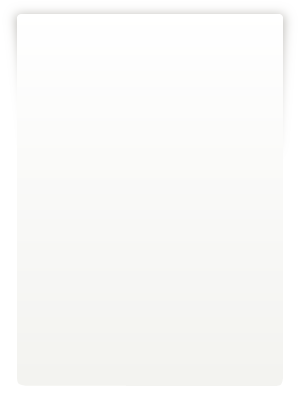
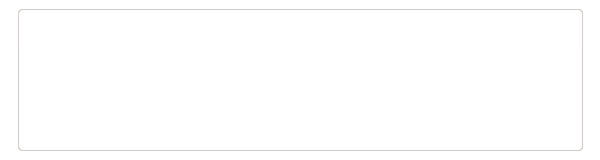
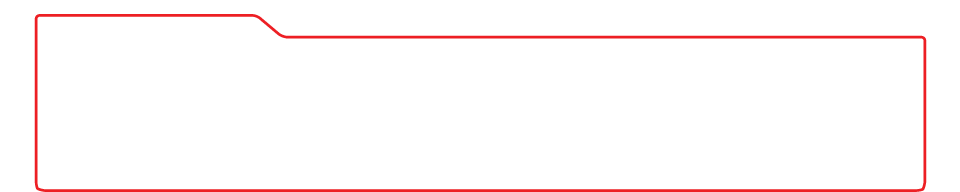
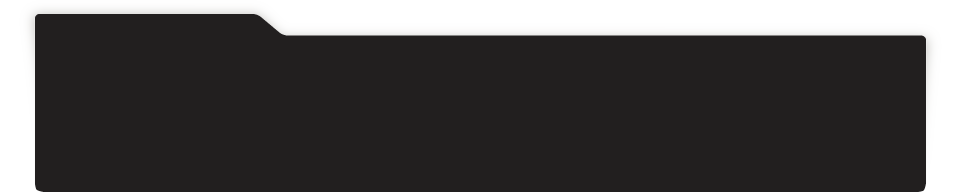
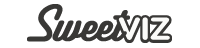
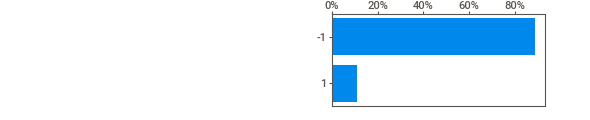
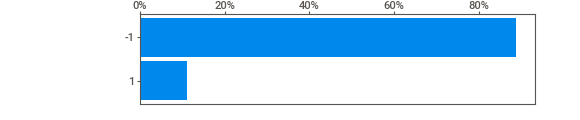
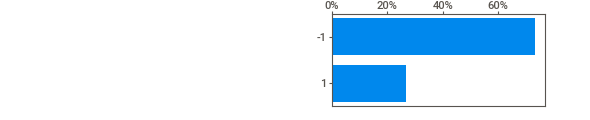
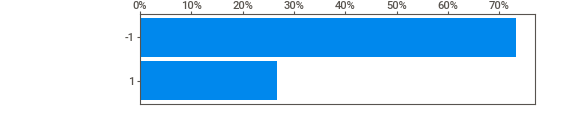
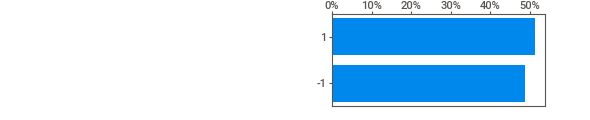
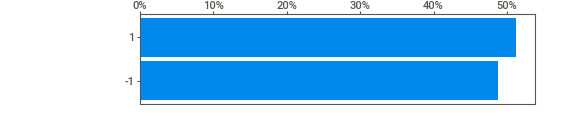
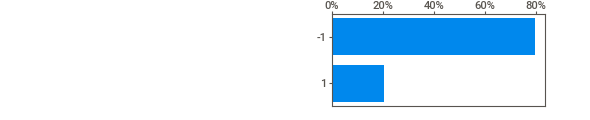
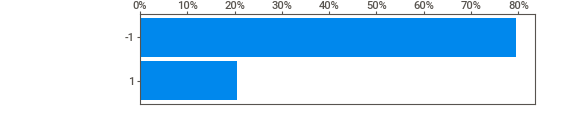
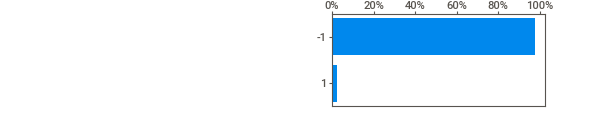
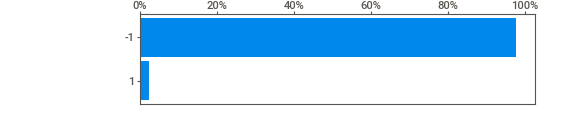
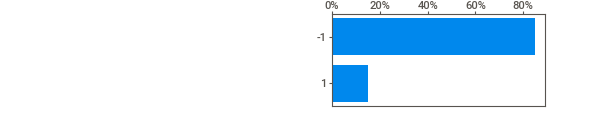
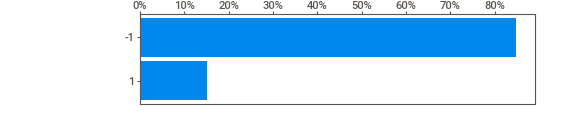
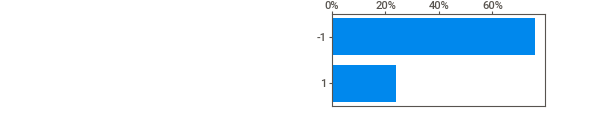
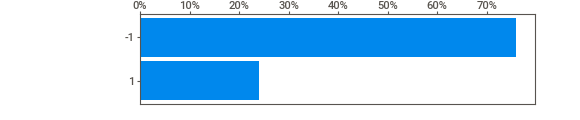
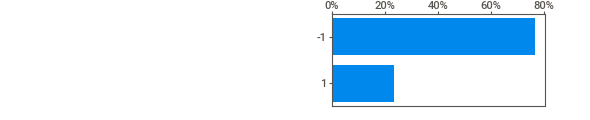
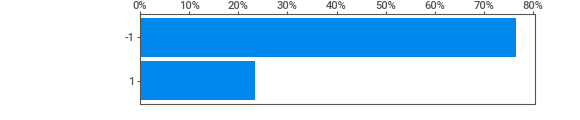
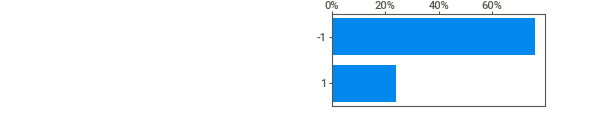
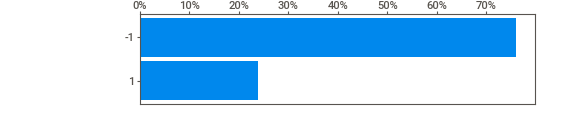
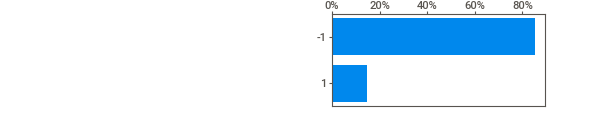
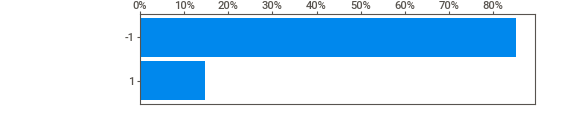
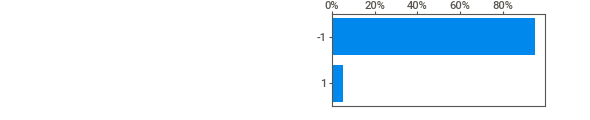
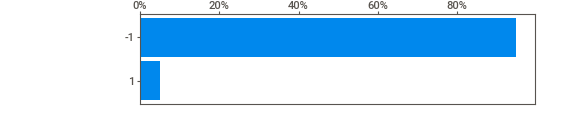
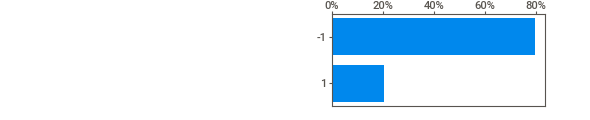
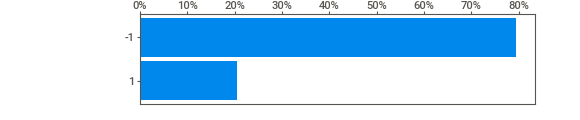
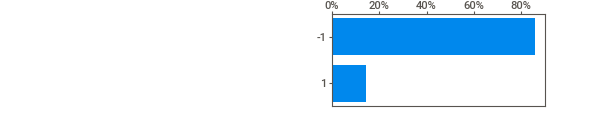
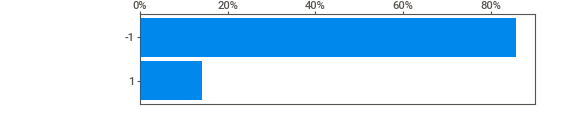
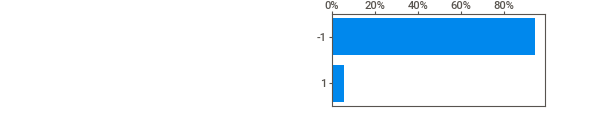
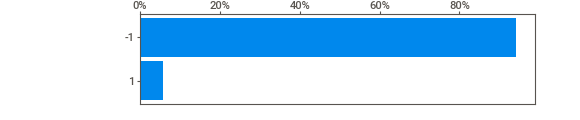
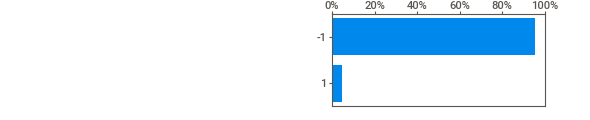
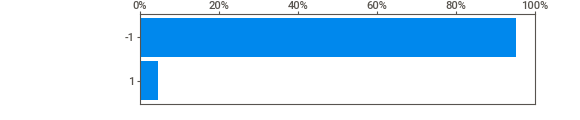
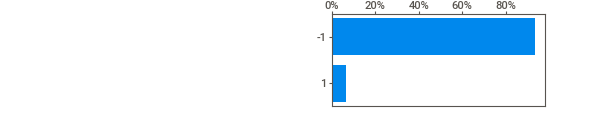
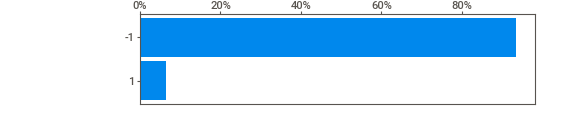
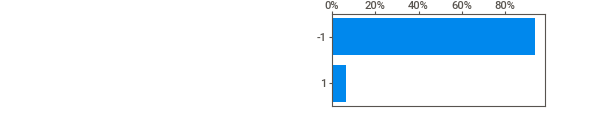
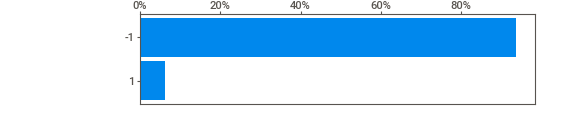
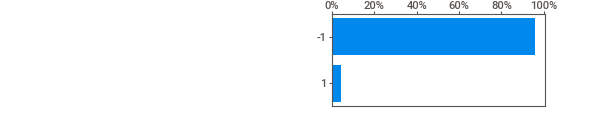
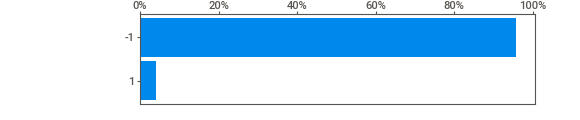
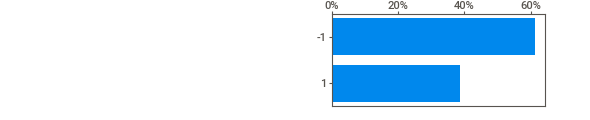
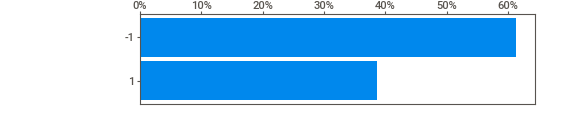
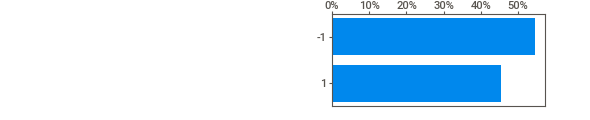
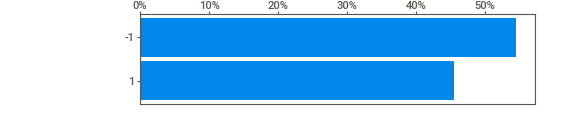
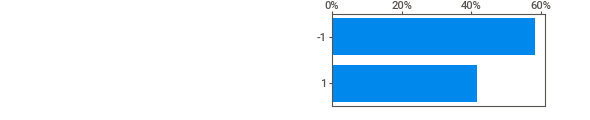
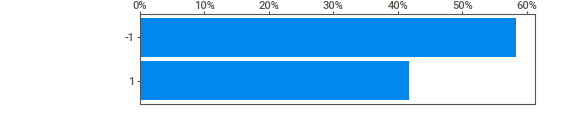
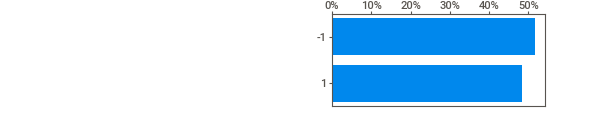
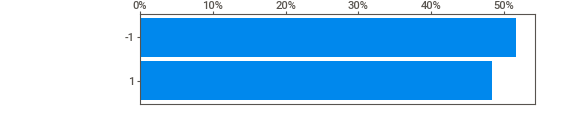
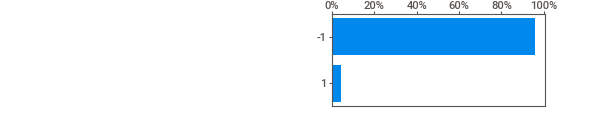
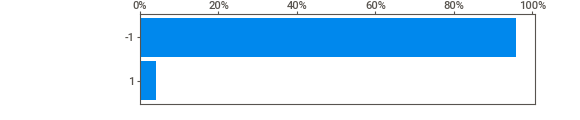
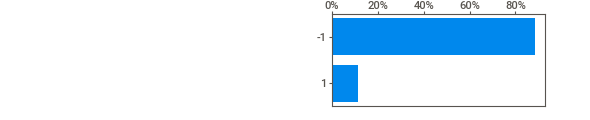
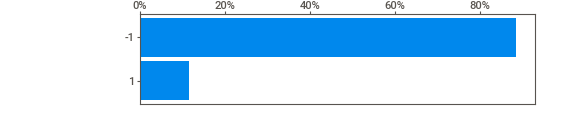
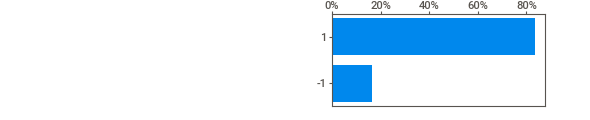
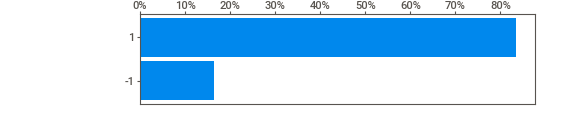
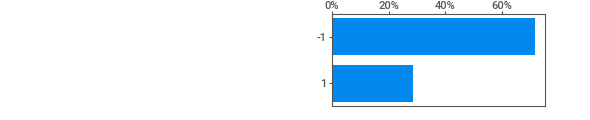
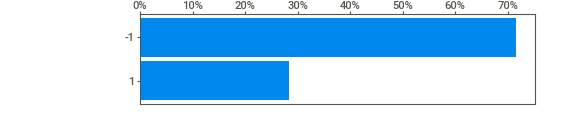
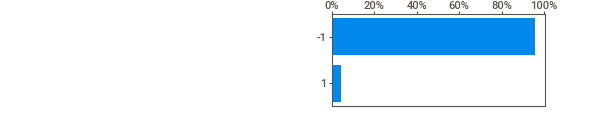
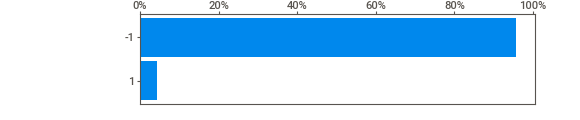
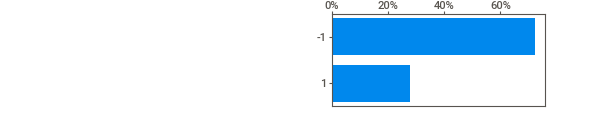
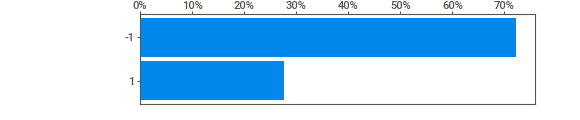
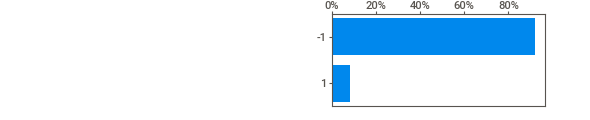
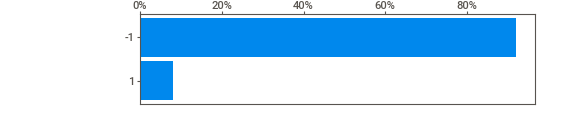
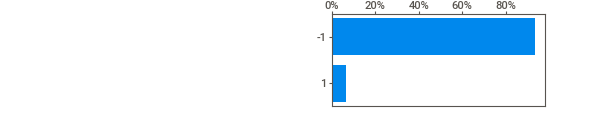
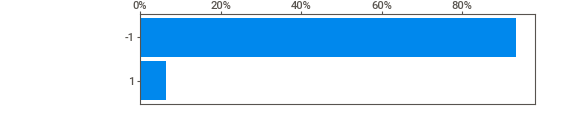
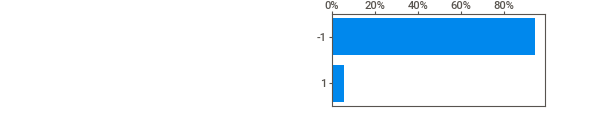
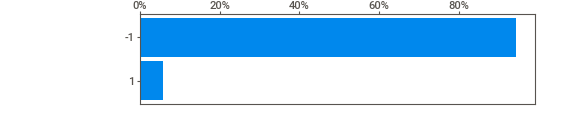
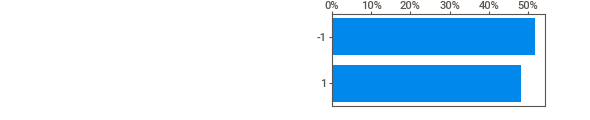
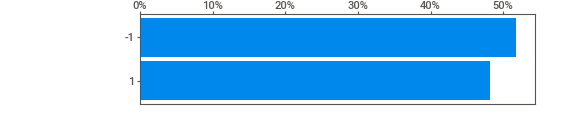
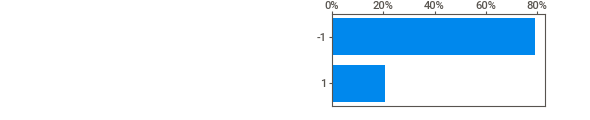
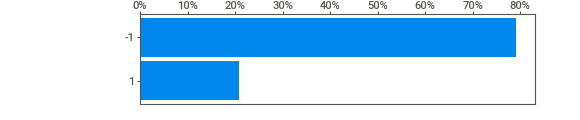
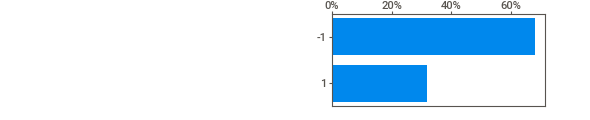
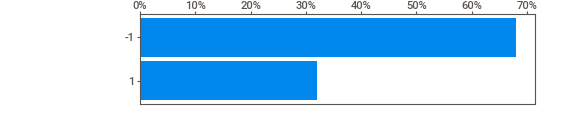
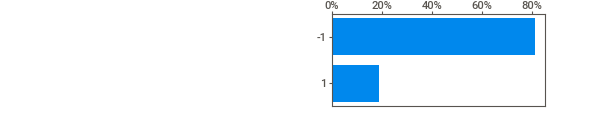
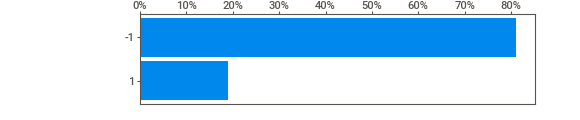
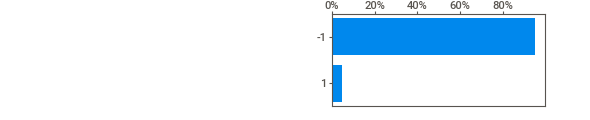
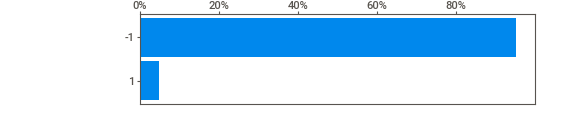
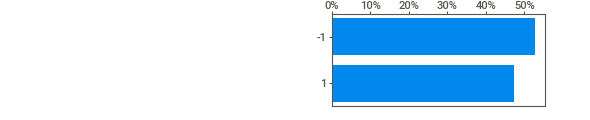
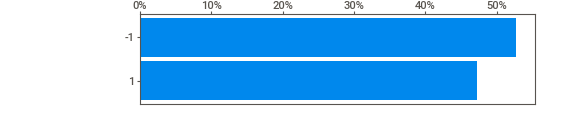
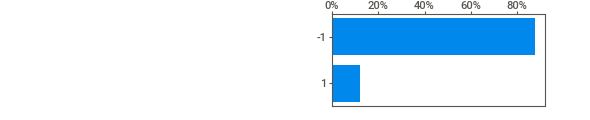
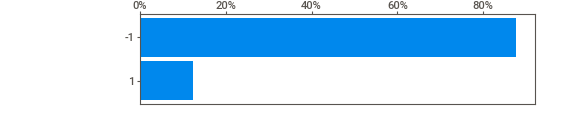
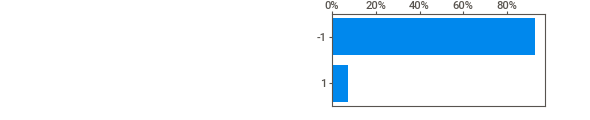
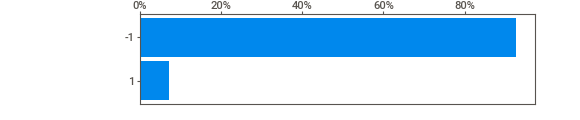
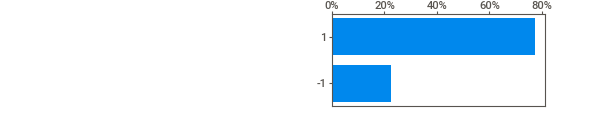
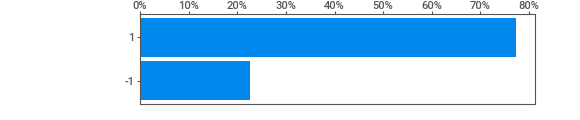

In [7]:
# !pip install sweetviz
import sweetviz as sv

skip_eda = False # if you dont want to use the eda.

if skip_eda == False:

    analysis = sv.analyze(list_attr_celeba, pairwise_analysis='off')

    analysis.show_notebook(w=None, h=None, scale=None, layout='widescreen', filepath=None)

## Lets do some face detection and downsampling

We ran the face_recognition on the all 200.000 images in the normal dataset. This takes approx. 45 mins. 

Instead of repeating the proces we read in the results.

(The code for face detection is in the next section)

In [8]:
# read in the data
not_found = pickle.load( open( "../data/not_found.p", "rb" ) )

not_found_img_ids = [not_found[i].name for i in range(len(not_found))]

nf_df = list_attr_celeba.query('image_id in @not_found_img_ids').set_index('image_id')
f_df = list_attr_celeba.query('image_id not in @not_found_img_ids').set_index('image_id')

**Here we downsample the found images to 40.000**

In [9]:
f_df = f_df.sample(n = 40000, random_state=42)

# Merge f_df and nf_df into one dataframe, add a column Recognized_normal = 1 if recognized, 0 if not recognized
f_df['Recognized_normal'] = 1
nf_df['Recognized_normal'] = 0

# And merge them here
data = pd.concat([f_df, nf_df], axis=0).reset_index()

In [10]:
data.head(5).T

,0,1,2,3,4
image_id,066574.jpg,194491.jpg,151301.jpg,089630.jpg,184562.jpg
5_o_Clock_Shadow,1,-1,-1,-1,-1
Arched_Eyebrows,-1,1,-1,-1,1
Attractive,-1,1,-1,1,-1
Bags_Under_Eyes,1,-1,1,-1,1
Bald,-1,-1,-1,-1,-1
Bangs,-1,-1,-1,-1,-1
Big_Lips,-1,-1,1,-1,1
Big_Nose,-1,-1,1,-1,1
Black_Hair,-1,-1,1,-1,1


Lets plot

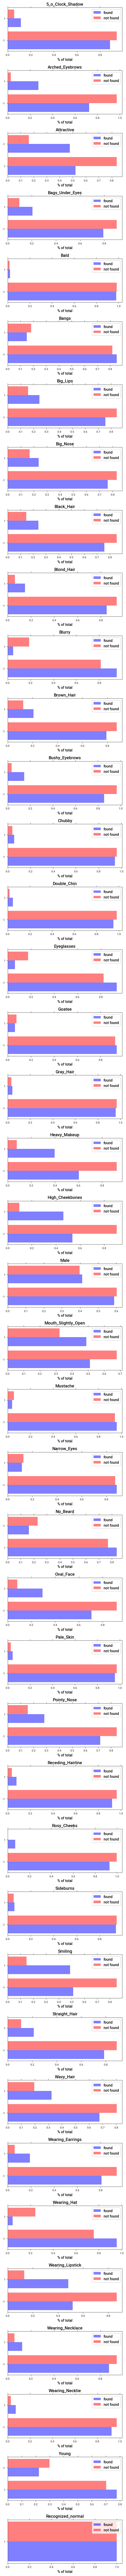

In [11]:
# Calculate the bar width and offset
bar_width = 0.4
bar_offset = bar_width/2

fig, axs = plt.subplots(nrows=len(f_df.columns), figsize=(5, 100))

for i, col in enumerate(f_df.columns):
    # Calculate the position for the bars
    positions = np.arange(len(f_df[col].value_counts()))

    # Plot the found count bars
    axs[i].barh(positions - bar_offset, f_df[col].value_counts()/len(f_df), height=bar_width, color='blue',
                alpha=0.5, label='found')

    # Plot the not found count bars
    axs[i].barh(positions + bar_offset, nf_df[col].value_counts()/len(nf_df), height=bar_width, color='red',
                alpha=0.5, label='not found')

    axs[i].set_yticks(positions)
    axs[i].set_yticklabels(f_df[col].value_counts().index)

    axs[i].tick_params(top=True)
    
    axs[i].set_xlabel('% of total')
    axs[i].set_title(col)
    axs[i].legend()


plt.tight_layout()
plt.show()

# Now we want to augment the images.

Here's an image

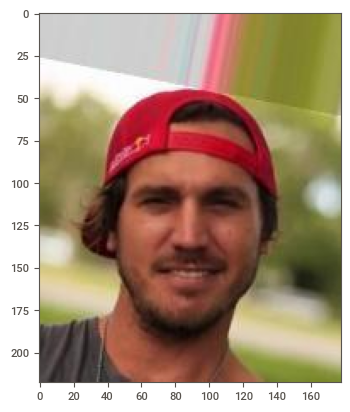

In [12]:
root_folder = '../data/celeb_dataset/img_align_celeba/normal/'

img_name = data.iloc[0]['image_id']
img = Image.open(root_folder + img_name)
img_np = np.asarray(img)
plt.imshow(img_np)

Here by increasing brightness

<class 'numpy.ndarray'>


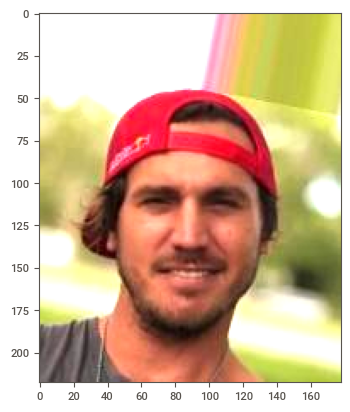

In [13]:
import torchvision.transforms.functional as F

brightness_factor = 1.5
img_adjusted = F.adjust_brightness(img, 1.5)
img_adjusted = np.asarray(img_adjusted)
print(type(img_adjusted))

# Display the brightness-adjusted image
plt.imshow(np.asarray(img_adjusted))

Here by contrast

<class 'numpy.ndarray'>


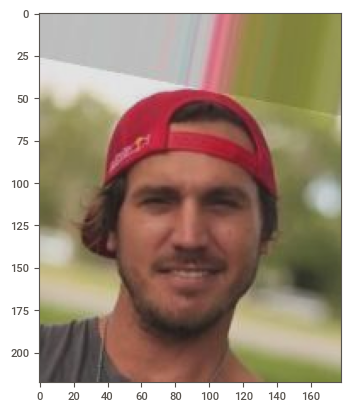

In [14]:
brightness_factor = 1.5
img_adjusted = F.adjust_contrast(img, 0.8)
img_adjusted = np.asarray(img_adjusted)
print(type(img_adjusted))

# Display the brightness-adjusted image
plt.imshow(np.asarray(img_adjusted))

In [15]:
# Here is a loop to do that for all images
run_cell = False

if run_cell == True:
    brigthness_preds = []
    for i in tqdm(range(len(sample_df))):
        img_name = sample_df.iloc[i]['image_id']
        img = Image.open(root_folder + img_name)
        img_adjusted = F.adjust_brightness(img, 1.5)
        br_img = np.asarray(img_adjusted)
        locs = face_recognition.face_locations(br_img)
        if len(locs) == 0:
            brigthness_preds.append(0)
        else:
            brigthness_preds.append(1)

        # Save the adjusted image
        img_adjusted.save(f"../data/celeb_dataset/img_align_celeba/brighter/{img_name}")
    

    contrast_preds = []
    for i in tqdm(range(len(sample_df))):
        img_name = sample_df.iloc[i]['image_id']
        img = Image.open(root_folder + img_name)
        img_adjusted = F.adjust_contrast(img, 1.2)
        br_img = np.asarray(img_adjusted)
        locs = face_recognition.face_locations(br_img)
        if len(locs) == 0:
            contrast_preds.append(-1)
        else:
            contrast_preds.append(1)

        # Save the adjusted image
        img_adjusted.save(f"../data/celeb_dataset/img_align_celeba/contrast/{img_name}")

Since dark_skin and lighter_skin got a bit blurry and faded we didnt keep the code for that.

However the images are in the data folder.

# Using face_recognition module to detect the faces

In [16]:
# We downsized the images. We are loading the downsized images here.

try:
    # Bence added all predictions.
    data = pd.read_csv('../data/preds_on_all_augmentations.csv').rename(columns={'found': 'Recognized'})
    print("Read in preds_on_all_augmentations.csv")

except:
    print("Could not find downsized_attributes_incl_darker_lighter.csv.")

    # we can use the dataframe from earlier.
    data = data

    print("Starting to recognize the images in the darker and lighter filtered images. This will take a while.")
    
    data['Recognized_normal'] = 1
    data['Recognized_lighter_skin'] = 1
    data['Recognized_darker_skin'] = 1
    data['Recognized_brighter'] = 1
    data['Recognized_contrast'] = 1

    data.shape, data.columns


    from pathlib import Path
    from tqdm import tqdm 
    import sys

    run_cell = True

    if run_cell == False:
        sys.exit()


    not_found_dict = {}
    # for folder in ['img_align_celeba', 'darker_skin', 'lighter_skin']:
    for folder in ['darker_skin', 'lighter_skin', 'brighter', 'contrast']:

        path = Path(f'../data/celeb_dataset/img_align_celeba/{folder}')
        image_paths = [path / img_id for img_id in data.image_id]

        not_found = []
        not_found_ids = []

        with tqdm(total=len(image_paths), desc='Processing Images') as pbar:
            # for img_path in image_paths:
            for img_path in image_paths[:1]:
                image = face_recognition.load_image_file(img_path)
                face_locations = face_recognition.face_locations(image)
                if len(face_locations) == 0:
                    not_found.append(img_path)
                    not_found_ids.append(img_path.name)
                
                # Update the progress bar
                pbar.update(1)

        not_found_dict[folder] = not_found

        for image_id in not_found_dict[folder]:
            data.loc[data['image_id'] == image_id.name, 'Recognized_' + folder] = -1

        # data.to_csv('../data/preds_on_all_augmentations.csv', index=False)
        print("Saved downsized_attributes_incl_darker_lighter.csv")

Read in preds_on_all_augmentations.csv


## 4. SHAP

**SHAP values**

We tried with SHAP values to see if it could be used for calculating the influence of the latent features. 

Since SHAP works by masking features and in that way calculate their influence, this didnt work. 

In [17]:
from pathlib import Path
import face_recognition

class FaceRecognitionModel:
    def predict(self, X):

        y_pred = []

        for i in X:

            # Image name from features
            image_name = i[0]

            # Load the image file
            path = Path('../data/celeb_dataset/img_align_celeba/normal/')
            image_path = path / image_name
            image = face_recognition.load_image_file(image_path)

            # Try to recognize the face
            face_loc = face_recognition.face_locations(image)
            
            if len(face_loc) == 0:
                y_pred.append(0)
            else:
                y_pred.append(1)
        
        return np.array(y_pred)

model = FaceRecognitionModel()
print("Test that it can predict:", model.predict(data.iloc[:3,:].values))

# X is all the attributes except the last column (Recognized)
X = data.iloc[:, 1:-5].values
y = data.iloc[:, -5].values
y_true = [1]*len(X)

Test that it can predict: [1 1 1]


The following code would give an error:

In [18]:
import shap

# Initialize the SHAP explainer with the face recognition model
# explainer = shap.KernelExplainer(model.predict, X)

# Calculate the SHAP values for the physical attributes
# shap_v = explainer.shap_values(X)

/Users/thomas/.pyenv/versions/3.11.1/envs/fairness/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/thomas/.pyenv/versions/3.11.1/envs/fairness/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/thomas/.pyenv/versions/3.11.1/envs/

## 5. White box model to explain - Decision Tree 

We want to try to create a DT classifier to find latent variables to the predicted output. In that way to check if there are any latent variables that might contribute to recognizing a face or not.

In [19]:
# The different targets from the augmentaitons
data.columns.to_list()[-5:]

['Recognized_normal',
 'Recognized_lighter_skin',
 'Recognized_darker_skin',
 'Recognized_brighter',
 'Recognized_contrast']

We are only looking on the output of the original dataset here, ["Recognized"].

So we are discarding the rest of the recocognized-columns.

In [20]:
# Se we are removing the last 4 columns, which are the augmentations.
data_normal = data.iloc[:, :-4]
data_normal.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'Recognized_normal'],
      dtype='object')

## Training the decision tree

Split the data

In [21]:
# In order to investigate the influnce of different latent features on the face recognition model,
# we will try to train a decision tree classifier on the latent features and the output of the face recognition model.

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

random_state = 42

X = data_normal.iloc[:, 1:-1].values
y = data_normal.iloc[:, -1].values

# replace all -1 with 0
y = np.where(y == -1, 0, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

Creating a function to do gridsearch

In [22]:
from sklearn.model_selection import GridSearchCV

def create_dt_with_grid_search(X_train, y_train, random_state=42):
    # Define the parameter grid to search over
    param_grid = {
        'max_depth': [3, 5, 7, 12, 15, 20, 25],
        'min_samples_split': [1, 2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5, 10, 20],
        'max_features': [None, 'sqrt', 5, 10]  # [None, 'sqrt', 5, 10]
    }

    # Create the decision tree classifier
    clf = DecisionTreeClassifier(random_state=random_state)

    # Create the grid search object
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Obtain the best parameters and best estimator from the grid search
    clf = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_

    return clf, best_params, best_accuracy

Lets see

In [23]:
if not skip_tree:

    # Create the decision tree classifier with grid search
    clf, best_params, best_accuracy = create_dt_with_grid_search(X_train, y_train)

    # get predictions
    y_pred = clf.predict(X_test)

    # Check parameters and metrics
    print("Scores without balancing the training data")
    print("Best Parameters:", best_params)
    print("Best Accuracy during training:", best_accuracy)
    print("Accuracy score: ", accuracy_score(y_test, y_pred))
    print("F1 score:       ", f1_score(y_test, y_pred))


    print("Lets examine the amount of each class in the prediction")
    print(np.unique(y_pred, return_counts=True))

Scores without balancing the training data
Best Parameters: {'max_depth': 12, 'max_features': 10, 'min_samples_leaf': 20, 'min_samples_split': 1}
Best Accuracy during training: 0.8866172604673203
Accuracy score:  0.8892786669590003
F1 score:        0.939773404889684
Lets examine the amount of each class in the prediction
(array([0, 1]), array([ 352, 8770]))


### Now instead we want to balance the training data

Balancing data, so there are an equal amount of recognized / not recognized faces in the training data

Splitting the data into test and train, while also balancing it.

In [24]:
from sklearn.utils import resample

def balance_data(X_train, y_train):
    # Find the minimum count among the labels
    min_count = min(np.bincount(y_train))

    # Resample instances for each unique label
    balanced_X = np.concatenate([resample(X_train[y_train == label], n_samples=min_count, replace=False)
                                 for label in np.unique(y_train)])
    balanced_y = np.concatenate([np.full(min_count, label) for label in np.unique(y_train)])

    return balanced_X, balanced_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, y_train = balance_data(X_train, y_train)

Trying to use gridsearch to find better params for the DT classifier.

In [25]:
if not skip_tree:
    
    # Create the decision tree classifier with grid search
    clf, best_params, best_accuracy = create_dt_with_grid_search(X_train, y_train)

    # get predictions
    y_pred = clf.predict(X_test)

    # Check parameters and metrics
    print("Scores when we balance the training data")
    print("Best Parameters:", best_params)
    print("Best Accuracy during training:", best_accuracy)
    print("Accuracy score: ", accuracy_score(y_test, y_pred))
    print("F1 score:       ", f1_score(y_test, y_pred))


    print("Lets examine the amount of each class in the prediction")
    print(np.unique(y_pred, return_counts=True))

    # Name features from clf.feature_importances_ with the names from data_normal.columns
    feature_importances = pd.DataFrame(
        clf.feature_importances_,
        index = data_normal.columns[1:-1],
        columns=['importance']).sort_values('importance', ascending=False)

    feature_importances.round(3).to_latex("../figures/feature_importances.tex")

    feature_importances

Scores when we balance the training data
Best Parameters: {'max_depth': 12, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 15}
Best Accuracy during training: 0.7849690317386806
Accuracy score:  0.7401885551414163
F1 score:        0.8305932809149392
Lets examine the amount of each class in the prediction
(array([0, 1]), array([3142, 5980]))


In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


**Visualize the decision tree**

In [26]:
# how to install:
#
# !pip install dtreeviz
#
# before, on mac:
# brew install graphviz
# test in cmd: dot -V

create_dtree = True

if create_dtree:
    import dtreeviz
    import graphviz.backend as be

    viz = dtreeviz.model(clf,
                    X_train,
                    y_train
                    )

    viz.view()

## 6. Fairness metrics

**Equalized odds**

True positive / False positive

So in this case, how many many cases did it predict a face of how many faces there actually were?

For each protected group.

In [27]:
print(data.Recognized_normal.value_counts())
print(data.Recognized_lighter_skin.value_counts())
print(data.Recognized_darker_skin.value_counts())
print(data.Recognized_brighter.value_counts())
print(data.Recognized_contrast.value_counts())

 1    40000
-1     5609
Name: Recognized_normal, dtype: int64
 1    39806
-1     5803
Name: Recognized_lighter_skin, dtype: int64
 1    39579
-1     6030
Name: Recognized_darker_skin, dtype: int64
 1    40288
-1     5321
Name: Recognized_brighter, dtype: int64
 1    40218
-1     5391
Name: Recognized_contrast, dtype: int64


## Statistical Parity

In [28]:
def statistical_parity(protected_feature, data=data, target='Recognized'):
    """
    Calculate the statistical parity for a given protected feature.
    
    Input protected_features: The columns name protected feature to calculate the equalized odds for.
    Returns the equalized odds for the given protected feature.
    """

    tpr = data.loc[(data[target] == 1) & (data[protected_feature] == 1)].shape[0]
    fpr = data.loc[(data[target] == -1) & (data[protected_feature] == 1)].shape[0]

    feature_1 = tpr/(tpr + fpr)

    tpr = data.loc[(data[target] == 1) & (data[protected_feature] == -1)].shape[0]
    fpr = data.loc[(data[target] == -1) & (data[protected_feature] == -1)].shape[0]

    feature_0 = tpr/(tpr + fpr)

    return feature_1, feature_0

# Now we are saving the equalized odds for each feature in a dataframe for later use
sp_df = pd.DataFrame(columns={'Feature': str, 'normal': float, 'darker_skin': float, 'lighter_skin': float, 'brighter': float, 'contrast': float})

features = ['Attractive', 'Chubby', 'Male', 'Pale_Skin']
features = list(data.columns)[1:-5]

for feature in features:

    stat_par_normal = np.round(statistical_parity(feature, data=data, target='Recognized_normal'), 3)
    stat_par_dark = np.round(statistical_parity(feature, data=data, target='Recognized_darker_skin'), 3)
    stat_par_light = np.round(statistical_parity(feature, data=data, target='Recognized_lighter_skin'), 3)
    stat_par_brighter = np.round(statistical_parity(feature, data=data, target='Recognized_brighter'), 3)
    stat_par_contrast = np.round(statistical_parity(feature, data=data, target='Recognized_contrast'), 3)


    sp_df.loc[len(sp_df)] = [feature + ", True", stat_par_normal[0], stat_par_dark[0], stat_par_light[0], stat_par_brighter[0], stat_par_contrast[0]]
    sp_df.loc[len(sp_df)] = [feature + ", False", stat_par_normal[1], stat_par_dark[1], stat_par_light[1], stat_par_brighter[1], stat_par_contrast[1]]


sp_df.to_latex("../figures/odds_all_features.tex", index=False)

sp_df

/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_6536/2647573668.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


,Feature,normal,darker_skin,lighter_skin,brighter,contrast
0,"5_o_Clock_Shadow, True",0.935,0.928,0.931,0.940,0.939
1,"5_o_Clock_Shadow, False",0.870,0.861,0.866,0.877,0.875
2,"Arched_Eyebrows, True",0.986,0.984,0.985,0.985,0.986
3,"Arched_Eyebrows, False",0.842,0.831,0.837,0.851,0.848
4,"Attractive, True",0.958,0.954,0.956,0.959,0.961
...,...,...,...,...,...,...
75,"Wearing_Necklace, False",0.869,0.859,0.865,0.876,0.874
76,"Wearing_Necktie, True",0.950,0.947,0.948,0.953,0.950
77,"Wearing_Necktie, False",0.872,0.862,0.867,0.878,0.877
78,"Young, True",0.888,0.879,0.884,0.894,0.893


We want to report the accuracy / stastical parity as a mean of all features.

In [29]:
sp_df.mean(axis=0).round(3).to_frame().T.to_latex("../figures/accuracy.tex", index=False)

sp_df.mean(axis=0).round(3).to_frame().T

/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_6536/466742398.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_6536/466742398.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_6536/466742398.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is dep

,normal,darker_skin,lighter_skin,brighter,contrast
0,0.882,0.873,0.878,0.888,0.887


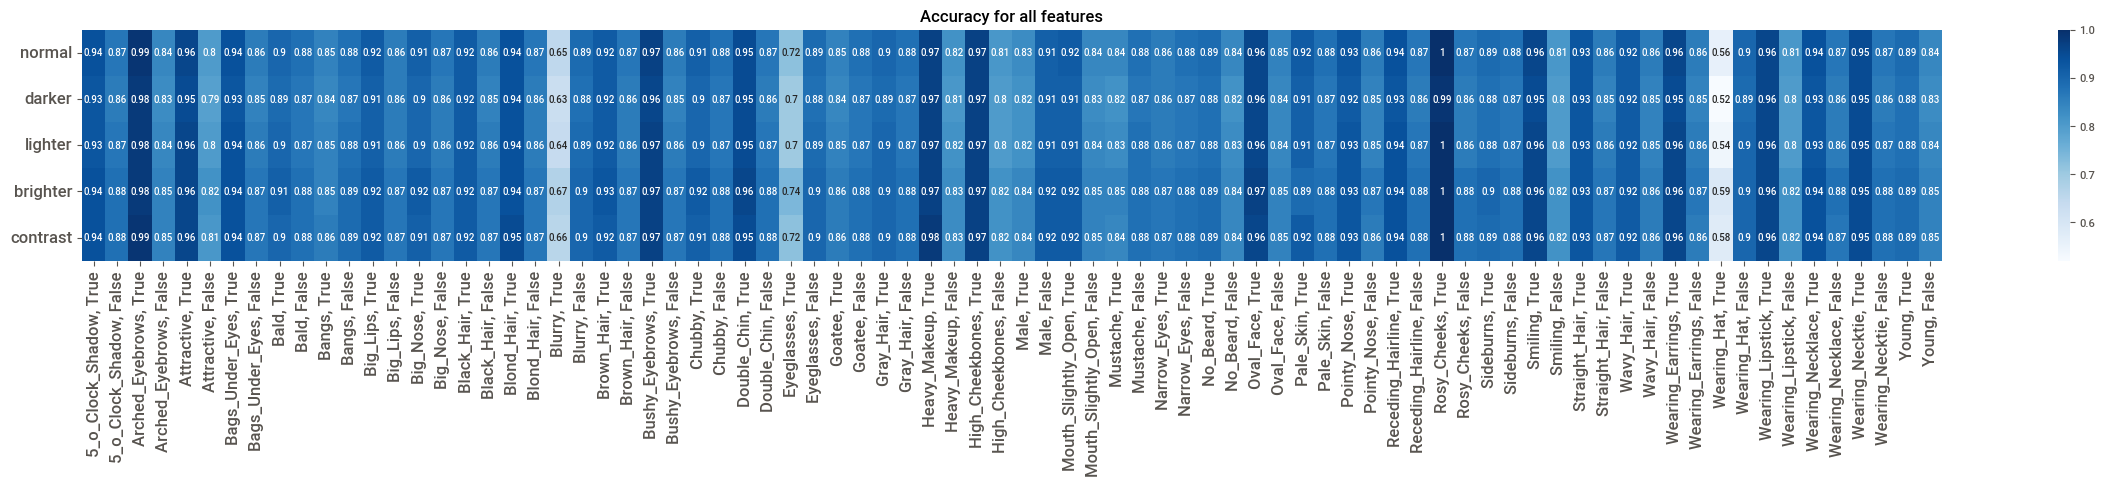

In [30]:
import seaborn as sns

#### prepare the dataframe
sp_plot = sp_df.set_index('Feature')
sp_plot = sp_plot.rename(columns={'normal': 'normal', 'darker_skin': 'darker', 'lighter_skin': 'lighter'})
sp_plot = sp_plot.round(2)

#### create the heatmap and set the settings
plt.figure(figsize=(30, 3))

# create the heatmap
sns.heatmap(sp_plot.T, annot=True, cmap='Blues', fmt='.3g', annot_kws={"fontsize": 7})

# set label size
plt.tick_params(labelsize=12)

# remove the x label
plt.xlabel('')

# rotate the y labels
plt.yticks(rotation=0)

# set the title 
plt.title('Accuracy for all features')

# save the figure and show it
plt.savefig('../figures/heatmap_odds.png', dpi=300, bbox_inches='tight')
plt.show()

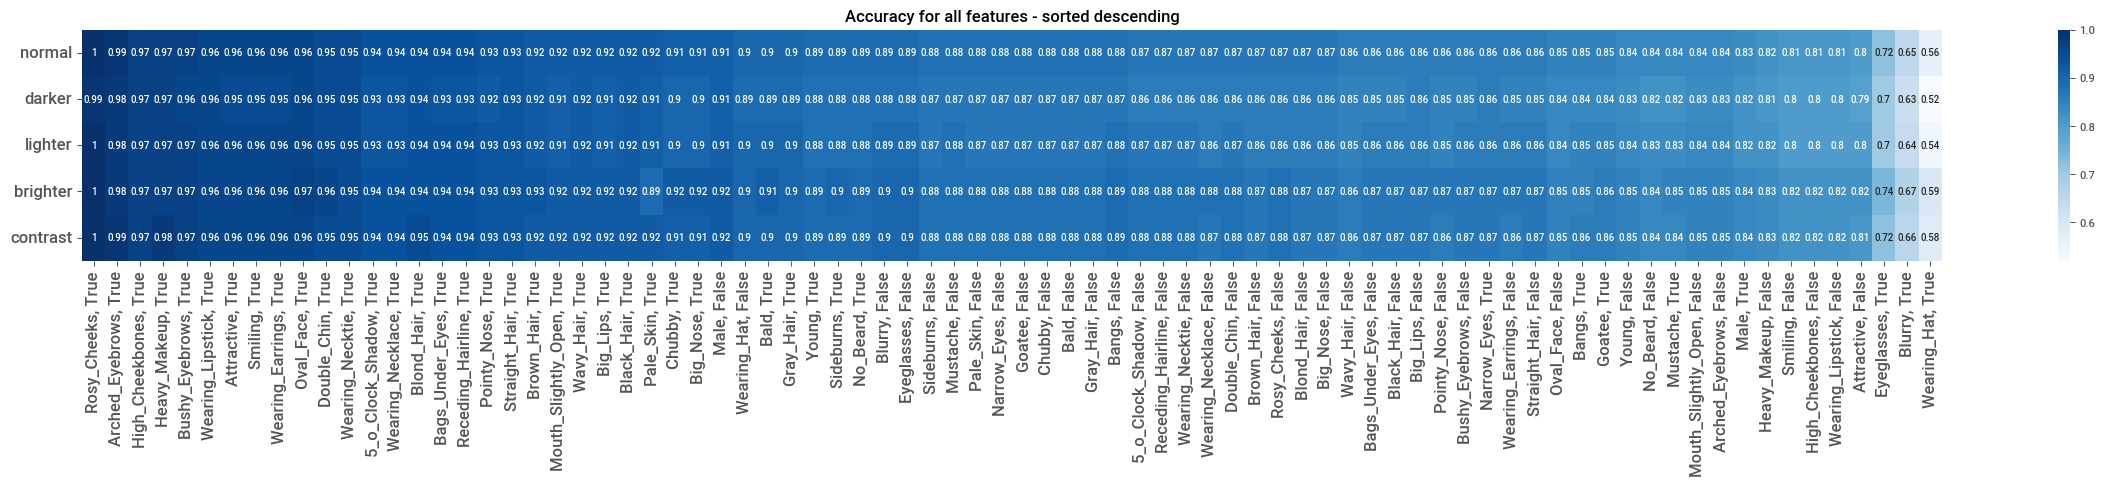

In [31]:
#### prepare the dataframe - this time by sorting it
odds_plot_sorted = sp_plot.sort_values(by=['normal'], ascending=False).copy() # thise time we sort it

#### create the heatmap and set the settings
plt.figure(figsize=(30, 3))

# create the heatmap
sns.heatmap(odds_plot_sorted.T, annot=True, cmap='Blues', fmt='.3g', annot_kws={"fontsize": 7})

# set label size
plt.tick_params(labelsize=12)

# remove the x label
plt.xlabel('')

# rotate the y labels
plt.yticks(rotation=0)

# set the title 
plt.title('Accuracy for all features - sorted descending')

# save the figure and show it
plt.savefig('../figures/heatmap_odds_sorted.png', dpi=300, bbox_inches='tight')
plt.show()

## Protected features and their combinations

In [32]:
data.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'Recognized_normal',
       'Recognized_lighter_skin', 'Recognized_darker_skin',
       'Recognized_brighter', 'Recognized_contrast'],
      dtype='object')

In [33]:
def equalized_odds_multiple(protected_features: list, combinations: list, data: pd.DataFrame,
                             target: list = 'Recognized', decimals: int = 3) -> int:
    """
    Calculate the equalized odds for a combination of values for some protected features.
    
    Input protected_features: The columns names protected feature to calculate the equalized odds for.
    Returns the equalized odds for the given protected feature.
    """
    eq_odds_all_combinations = []

    for feature_values in combinations:

        condition = True
        for feature, value in zip(protected_features, feature_values):
            condition &= (data[feature] == value)

        tpr = data.loc[(data[target] == 1) & condition].shape[0]
        fpr = data.loc[(data[target] == -1) & condition].shape[0]

        eq_odds = np.round(tpr/(tpr + fpr), decimals)

        eq_odds_all_combinations.append(eq_odds)

    return eq_odds_all_combinations


def label_combinations(protected_features: dict) -> list:
    """
    Function returns all combinations of the protected features and labels them.

    Input should be a dict, where columns names are stored in keys and values are
    the labels for the binary values are stored in a list. E.g.:
    
    protected_features = {'Attractive': ['Attractive', 'Unattractive']}
    """    

    import itertools

    # get all possible combinations of the protected features
    combinations = list(itertools.product([1, -1], repeat=len(protected_features)))

    c = np.array(combinations)
    combinations = c[np.lexsort((-c[:, 2], -c[:, 0], -c[:, 1], -c[:, 3]))]
    combinations.tolist()

    prot_list = list(protected_features.values())
    comb_list = []

    # label the combinations
    for combination in combinations:
        c_str = ""

        for idx, value in enumerate(combination):
            # get correct index in dict
            if value == -1:
                value = 2
            
            c_str += prot_list[idx][value - 1]

            # add , between the features
            if idx != len(combination)-1:
                c_str += ", "

        comb_list += [c_str]

    return combinations, comb_list


def add_zeros_to_decimals(df, decimals=3):
    """
    Function that formats all numbers in a dataframe
    """
    def format_decimal(val):
        if isinstance(val, (float, np.floating)) and not np.isnan(val):
            decimal_part = str(val).split('.')[-1]
            if len(decimal_part) < decimals:
                return '{:.{}f}'.format(val, decimals)
        return val

    formatted_df = df.applymap(format_decimal)
    return formatted_df



def combine_odds_df(protected_features: list, combinations: list, data: pd.DataFrame) -> pd.DataFrame:
    """
    Function that calculated equalized odds for all combinations of protected features 
    and returns a dataframe with the results.

    Input:
    - protected_features: list of column names of protected features
    - combinations: list of all combinations of protected features
    - data: dataframe with the data
    """


    # Going through all targets in the columns
    # first target is renamed to normal and manually added to the dataframe
    prot_odds = pd.DataFrame([
                        comb_list, 
                        equalized_odds_multiple(protected_features, combinations, data, target='Recognized_normal', decimals = 3)
                        ], index=['Feature', 'normal']).T

    # all other targets are added to the dataframe here
    for target in data.columns.to_list()[-4:]:

        col_name = target.replace("Recognized_", "")

        df = pd.DataFrame([
                        comb_list, 
                        equalized_odds_multiple(protected_features, combinations, data, target=target, decimals = 3)
                        ], index=['Feature', col_name]).T

        prot_odds = pd.concat([prot_odds, df[col_name]], axis=1)

    # add a mean for each column
    # add mean for each column without
    prot_odds.loc['mean'] = prot_odds.mean()

    # for each column, we calculate the difference from the standard deviation
    prot_odds.loc['std'] = (prot_odds.iloc[:-1, 1:].apply(lambda x: x - x.mean())**2).sum()/prot_odds.iloc[:-1, 1:].shape[0]

    # format the the cells so there are 3 decimals
    prot_odds = add_zeros_to_decimals(prot_odds)

    # divide the feature name into separate columns
    prot_odds[['age', 'gender', 'attrativeness', 'skin']] = prot_odds['Feature'].str.split(', ', expand=True)

    # protected feature names
    prot = list(protected_features.keys())
    # count number of people in each group
    ls_c = []

    for c in combinations:
        counts = data[(data[prot[0]] == c[0]) & (data[prot[1]] == c[1]) & (data[prot[2]] == c[2]) & (data[prot[3]] == c[3])].shape[0]
        percentage = np.round(counts/data.shape[0]*100, 2)
        ls_c += [percentage]

    ls_c += [None, None]
    prot_odds['% people'] = ls_c

    # Reorder the columns
    prot_odds = prot_odds[['skin', 'gender', 'age', 'attrativeness', '% people', 'normal', 'lighter_skin', 'darker_skin', 'brighter', 'contrast']]

    return prot_odds

In [34]:
# we have chosen the following protected features
# the dict have labels for the different binairy values,
# the first is the label of the positive value, the second is the label of thenegative value
protected_features = {
    'Young': ['young', 'old'],
    'Male': ['male', 'female'],
    'Attractive': ['attractive', 'not attractive'],
    'Pale_Skin': ['pale skin', 'not pale skin']
    }

# get labeled combinations
combinations, comb_list = label_combinations(protected_features)

# calculate the equalized odds for all combinations
prot_odds = combine_odds_df(protected_features, combinations, data)

# exported to csv
prot_odds.to_latex('../figures/odds_table.tex', index=False)

prot_odds

/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_6536/3212972528.py:118: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_6536/1252639154.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


,skin,gender,age,attrativeness,% people,normal,lighter_skin,darker_skin,brighter,contrast
0,pale skin,male,young,attractive,0.50,0.948,0.952,0.943000,0.930,0.952
1,pale skin,male,young,not attractive,0.27,0.815,0.815,0.815000,0.798,0.823
2,pale skin,male,old,attractive,0.02,0.909,0.909,0.909000,0.909,0.909
3,pale skin,male,old,not attractive,0.21,0.844,0.823,0.823000,0.802,0.854
4,pale skin,female,young,attractive,2.26,0.952,0.948,0.948000,0.928,0.954
5,pale skin,female,young,not attractive,0.53,0.820,0.803,0.783000,0.775,0.824
6,pale skin,female,old,attractive,0.14,0.985,0.985,0.985000,0.939,0.985
7,pale skin,female,old,not attractive,0.21,0.885,0.885,0.875000,0.875,0.906
8,not pale skin,male,young,attractive,9.35,0.959,0.956,0.954000,0.963,0.962
9,not pale skin,male,young,not attractive,17.24,0.775,0.769,0.761000,0.790,0.783
